In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 



from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'
root = '/g/data/e14/pc5520/SWMT/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34711,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:41963,Total threads: 6
Dashboard: /proxy/41431/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36631,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2155-01-01'

lat_slice  = slice(-79.59,-58.98)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006


100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


1

In [6]:
def save_SWMT(expt, session, start_time, end_time, outpath, lat_north = -59, n = None, basal=None):
    '''
    Computes southern ocean surface water-mass transformation rates (partitioned into transformation from heat 
    and freshwater) referenced to 1000 db from monthly ACCESS-OM2 output.
    Suitable for analysis of high-resolution (0.1 degree) output (the scattered .load()'s allowed this)
    
    expt - text string indicating the name of the experiment
    session - a database session created by cc.database.create_session()  
    start_time - text string designating the start month of the analysis ('YYYY-MM', e.g. '1905-01')
    end_time - text string indicating the end month of the analysis ('YYY-MM', e.g. '1905-12')
    outpath - text string indicating directory where output databases are to be saved (3 xarray databases, can
    modify to combine these if memory permits)
    lat_north - function computed processes between lat = -90 and lat = lat_north
    n - designate if a subset of output files is to be considered (see cc.querying.getvar)
    
    NOTE: this function assumes you are averaging over an integer number of years (though the start month 
    need not be january, e.g. can have start_time = '1905-05', end_time = '1907-04' etc), modify if otherwise.
    
    NOTE: assumes surface_temp and surface_salt variables are in potential temperature (K) and practical
    salinity (PSU), simplifications may be made if conservative temperature (C) and absolute salinity (g/kg)
    are computed online
    
    required modules:
    xarray as xr
    numpy as np
    cosima_cookbook as cc
    from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
    '''
    ## getvar all required variables
    SST = cc.querying.getvar(expt,'surface_temp',session,ncfile='ocean_month.nc') - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    SSS_PSU = cc.querying.getvar(expt,'surface_salt',session,ncfile='ocean_month.nc') # SSS - practical salinity (not absolute)
    pme_river = cc.querying.getvar(expt,'pme_river',session,ncfile='ocean_month.nc') # mass flux of precip - evap + river
    sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,ncfile='ocean_month.nc')
    sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,ncfile='ocean_month.nc')
    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,ncfile='ocean_month.nc') # W/m2
    if basal == True:
        hflux_from_basal = cc.querying.getvar(expt, 'temp_basalmix', session, frequency='1 monthly')
        sfc_hflux_from_runoff_con = cc.querying.getvar(control,'sfc_hflux_from_runoff',master_session,ncfile='ocean_month.nc') # W/m2
        basal_fwflx = cc.querying.getvar(expt, 'basal_fwflx2d', session, frequency='1 monthly')
    sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,ncfile='ocean_month.nc') # W/m2
    sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,ncfile='ocean_month.nc') # W/m2
    frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,ncfile='ocean_month.nc') # W/m2
    geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
    geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time,end_time)
    #lat_slice = slice(-90,lat_north)
    lat_slice = slice(-79.59,-58.98)
    SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
    if basal == True:
        hflux_from_basal_a = hflux_from_basal.sel(time=time_slice)
        hflux_from_basal = hflux_from_basal_a[:,:,36:,:].sel(time=time_slice, yt_ocean_sub01=lat_slice)
        hflux_from_basal = hflux_from_basal.rename(({'xt_ocean_sub01':'xt_ocean', 'yt_ocean_sub01':'yt_ocean'}))
        hflux_from_basal.coords['yt_ocean'] = sfc_hflux_from_runoff['yt_ocean'].values
        hflux_from_basal.coords['xt_ocean'] = sfc_hflux_from_runoff['xt_ocean'].values
        hflux_from_basal = hflux_from_basal.sum('st_ocean')
        sfc_hflux_from_runoff_con = sfc_hflux_from_runoff_con.sel(time=time_slice, yt_ocean=lat_slice)
        sfc_hflux_from_calving = sfc_hflux_from_runoff_con * 0.5
        basal_fwflx_a = basal_fwflx.sel(time=time_slice)
        basal_fwflx = basal_fwflx_a[:,36:,:].sel(time=time_slice, yt_ocean_sub01=lat_slice)
        basal_fwflx = basal_fwflx.rename(({'xt_ocean_sub01':'xt_ocean', 'yt_ocean_sub01':'yt_ocean'}))
        basal_fwflx.coords['yt_ocean'] = sfc_hflux_from_runoff['yt_ocean'].values
        basal_fwflx.coords['xt_ocean'] = sfc_hflux_from_runoff['xt_ocean'].values  
    sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
    frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
    lon_t = geolon_t.sel(yt_ocean=lat_slice)
    lat_t = geolat_t.sel(yt_ocean=lat_slice)
    ## extract coordinate arrays
    yt_ocean = SST.yt_ocean.values
    xt_ocean = SST.xt_ocean.values
    time_monthly = SST.time.values
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SST.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap
    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
    ## compute net surface heat flux from its component terms
    net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    if basal == True:
        net_surface_heating = net_surface_heating + hflux_from_basal + sfc_hflux_from_calving
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -0.541281 # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0+1)*depth
    pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    ## Adjust pme_river
    if basal == True:
        pme_river = pme_river - (sfc_salt_flux_ice + sfc_salt_flux_restore)/SSS + basal_fwflx
    else:
        pme_river = pme_river - (sfc_salt_flux_ice + sfc_salt_flux_restore)/SSS
    ##  
    pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = pot_rho_1.load()
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
    salt_transformation = haline_contraction*SSS*pme_river*days_per_month #! before was PSU, why?
    salt_transformation = salt_transformation.load()
    # Compute heat transformation (no density binning)
    thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
    heat_transformation =  thermal_expansion*net_surface_heating*days_per_month
    heat_transformation = heat_transformation.load()
    # Record the time bounds before summing through time (just to make sure it's consistent with requested years)
    time_bounds =  str(salt_transformation.coords['time.year'][0].values)+'_'+str(salt_transformation.coords['time.month'][0].values)+'-'+str(salt_transformation.coords['time.year'][-1].values)+'_'+str(salt_transformation.coords['time.month'][-1].values)
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31, 33.5, 0.02) ## alter if this density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
    
    bin_bottoms = isopycnal_bins[:-1]
    binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
    binned_salt_transformation.chunk({'isopycnal_bins':1})
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,:,:] = masked_transform
    print('salt_transformation binning done')
    
    binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
    binned_heat_transformation.chunk({'isopycnal_bins':1})

    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (heat_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,:,:] = masked_transform
    print('heat_transformation binning done')
    
    ndays = days_per_month.sum().values
    salt_transformation = binned_salt_transformation/ndays
    c_p = 3992.1
    heat_transformation = binned_heat_transformation/c_p/ndays
    
    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis]
    heat_transformation = heat_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis]
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2
    
    # this procedure defines fluxes from lighter to denser classes as negative, I want the opposite
    salt_transformation = salt_transformation *-1
    heat_transformation = heat_transformation *-1
    
    # Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
    ds = xr.Dataset({'binned_salt_transformation': salt_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/ST_'+time_bounds+'.nc')
    ds = xr.Dataset({'binned_heat_transformation': heat_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/HT_'+time_bounds+'.nc')
    #############################################################
    net_transformation = heat_transformation + salt_transformation
    #############################################################
    del(heat_transformation, salt_transformation) ## unecessary for lower res or smaller time
    # wanted to rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
    net_transformation.coords['isopycnal_bins'] = isopycnal_bin_mid
    ds = xr.Dataset({'surface_water_mass_transformation': net_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+'/SWMT_'+time_bounds+'.nc')
    del(net_transformation)
    return outpath, time_bounds ## helpful for re-loading

In [7]:
expt = control
session = master_session
test = cc.querying.getvar(expt,'surface_temp',session, ncfile='ocean_month.nc')
#test.time ## want to see what the latest years look like

In [10]:
year=2154
## Make a temporary directory to stash a few files
!mkdir -p $root/control/SWMT_temp/$year
outpath = root+'control/SWMT_temp/'+str(year) # use a path where you have write permission

In [11]:
%%time
outpath, time_bounds = save_SWMT(expt, session, str(year)+'-01', str(year)+'-12', outpath,basal=False)

salt_transformation binning done
heat_transformation binning done
CPU times: user 2min 44s, sys: 59.3 s, total: 3min 43s
Wall time: 5min 29s


In [12]:
#4. Reload computed surface water-mass transformation

In [13]:
def get_SWMT(outpath, time_bounds):

    net_transformation = xr.open_dataset(outpath + '/SWMT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + '/HT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + '/ST_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation



In [14]:
#5. Plotting options: summed over southern ocean, south of 59S

In [16]:
year = 2150
outpath = root+'control/SWMT_temp/'+str(year)
time_bounds = str(year)+'_1-'+str(year)+'_12'
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # needed for the plots I'll provide.
swmt_con, heat_con, salt_con = get_SWMT(outpath, time_bounds)
## sum over region, convert to Sv
isopycnal_bin_mid_con = swmt_con.isopycnal_bins
swmt_con_sum = (swmt_con * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_con_sum = (heat_con * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_con_sum = (salt_con * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values

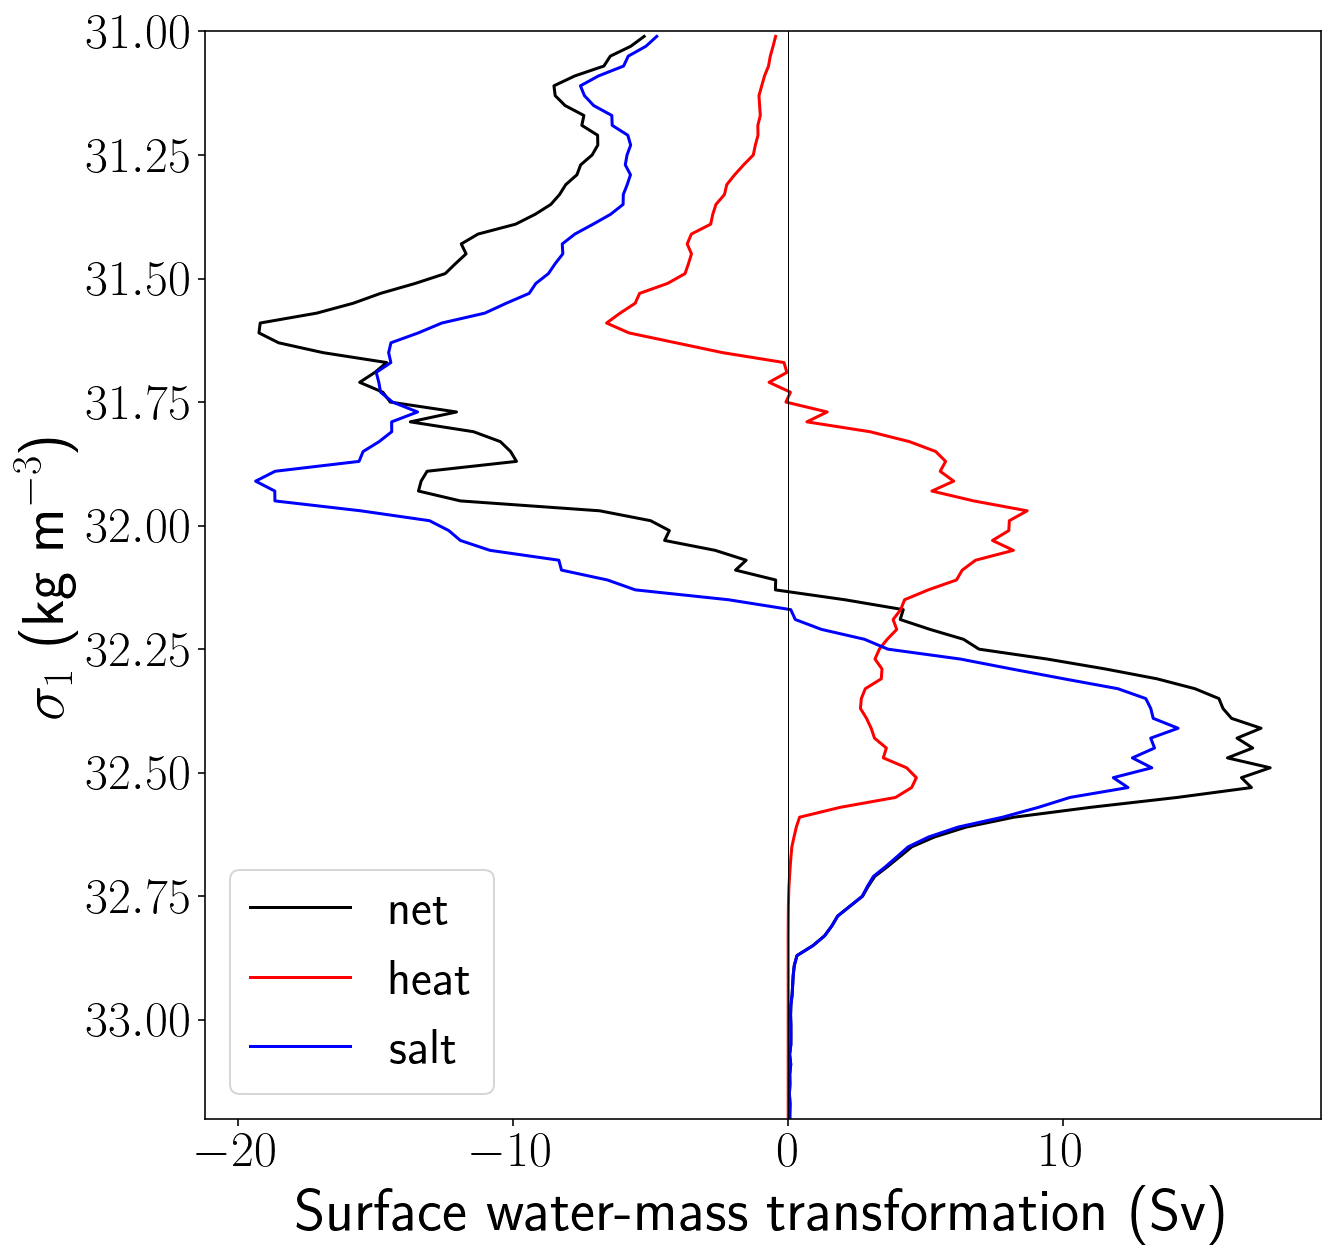

In [17]:
figure = plt.figure(num=1, figsize = (10, 10))
plt.plot(swmt_con_sum,isopycnal_bin_mid_con, color = 'k', label='net')
plt.plot(heat_con_sum,isopycnal_bin_mid_con, color = 'r', label='heat')
plt.plot(salt_con_sum,isopycnal_bin_mid_con, color = 'b', label='salt')
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

In [18]:
expt = Tfreezing_min
session = basal_melt_session
test = cc.querying.getvar(expt,'surface_temp',session, ncfile='ocean_month.nc')
#test.time ## want to see what the latest years look like

In [62]:
year=2154
## Make a temporary directory to stash a few files
!mkdir -p $root/Tfreezing_min/SWMT_temp/$year
outpath = root+'Tfreezing_min/SWMT_temp/'+str(year) # use a path where you have write permission

In [63]:
%%time
outpath, time_bounds = save_SWMT(expt, session, str(year)+'-01', str(year)+'-12', outpath,basal=True)

salt_transformation binning done
heat_transformation binning done
CPU times: user 4min 37s, sys: 56.3 s, total: 5min 33s
Wall time: 5min 46s


In [21]:
year = 2150
outpath = root+'Tfreezing_min/SWMT_temp/'+str(year)
time_bounds = str(year)+'_1-'+str(year)+'_12'
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # needed for the plots I'll provide.
swmt_Tfreezing_min, heat_Tfreezing_min, salt_Tfreezing_min = get_SWMT(outpath, time_bounds)
## sum over region, convert to Sv
isopycnal_bin_mid_Tfreezing_min = swmt_Tfreezing_min.isopycnal_bins
swmt_Tfreezing_min_sum = (swmt_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_Tfreezing_min_sum = (heat_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_Tfreezing_min_sum = (salt_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values

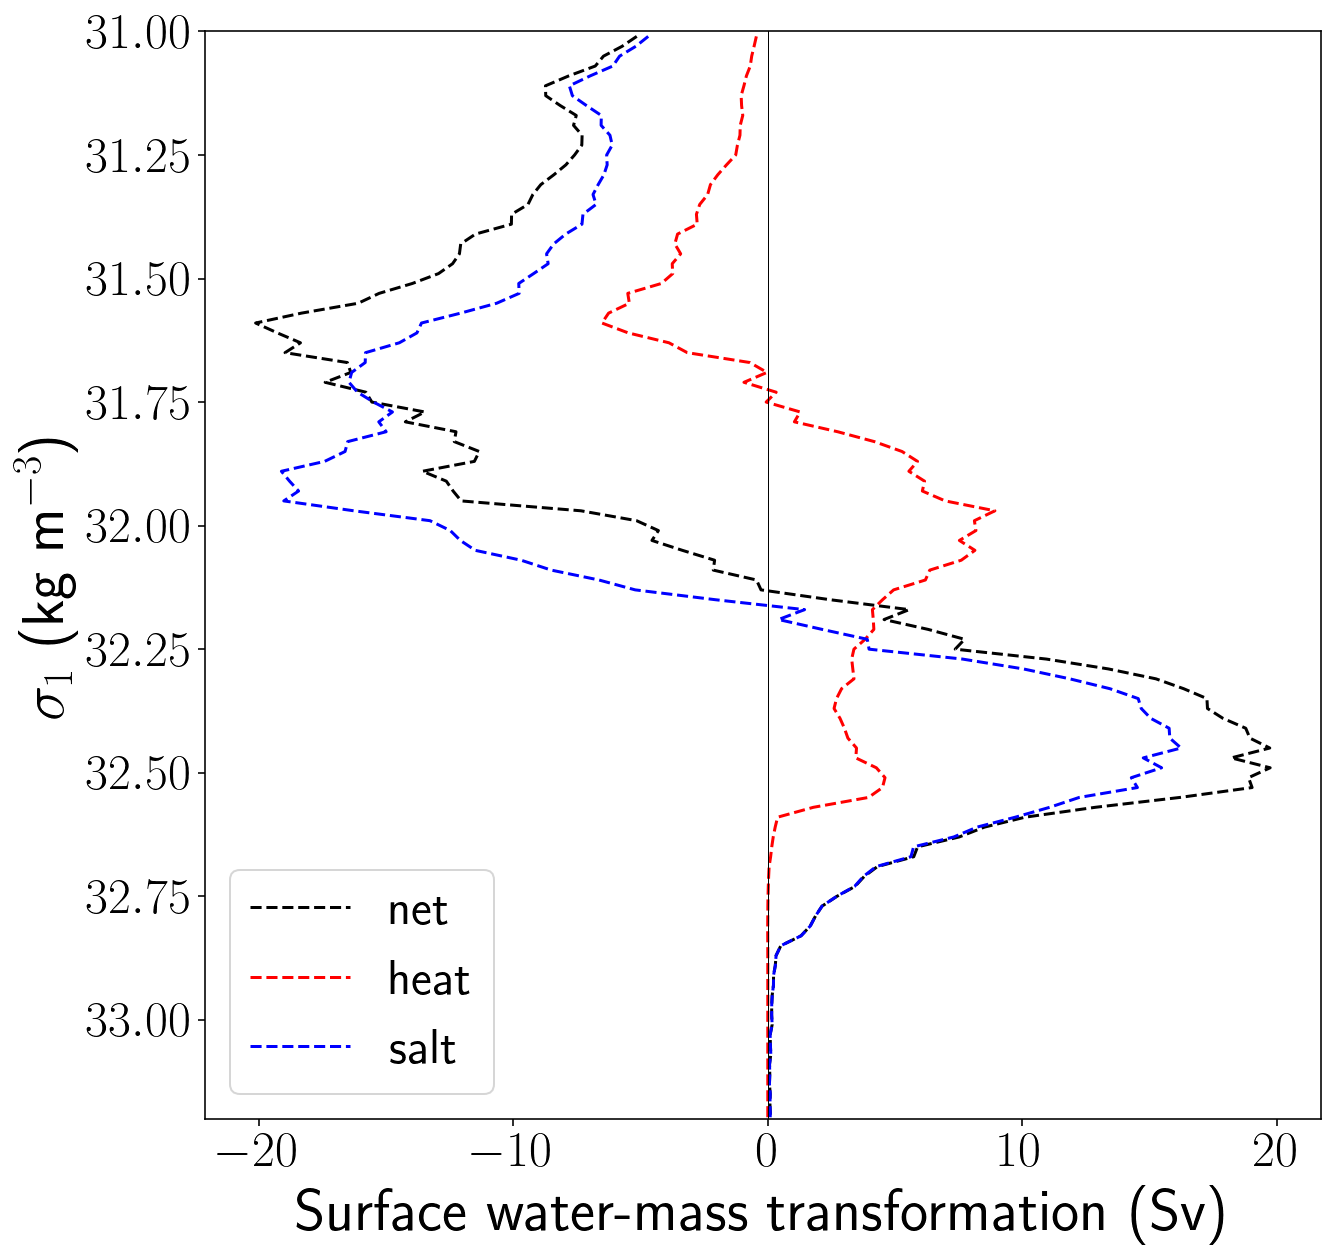

In [22]:
figure = plt.figure(num=1, figsize = (10, 10))
plt.plot(swmt_Tfreezing_min_sum,isopycnal_bin_mid_Tfreezing_min, color = 'k', linestyle='dashed', label='net')
plt.plot(heat_Tfreezing_min_sum,isopycnal_bin_mid_Tfreezing_min, color = 'r', linestyle='dashed', label='heat')
plt.plot(salt_Tfreezing_min_sum,isopycnal_bin_mid_Tfreezing_min, color = 'b', linestyle='dashed', label='salt')
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

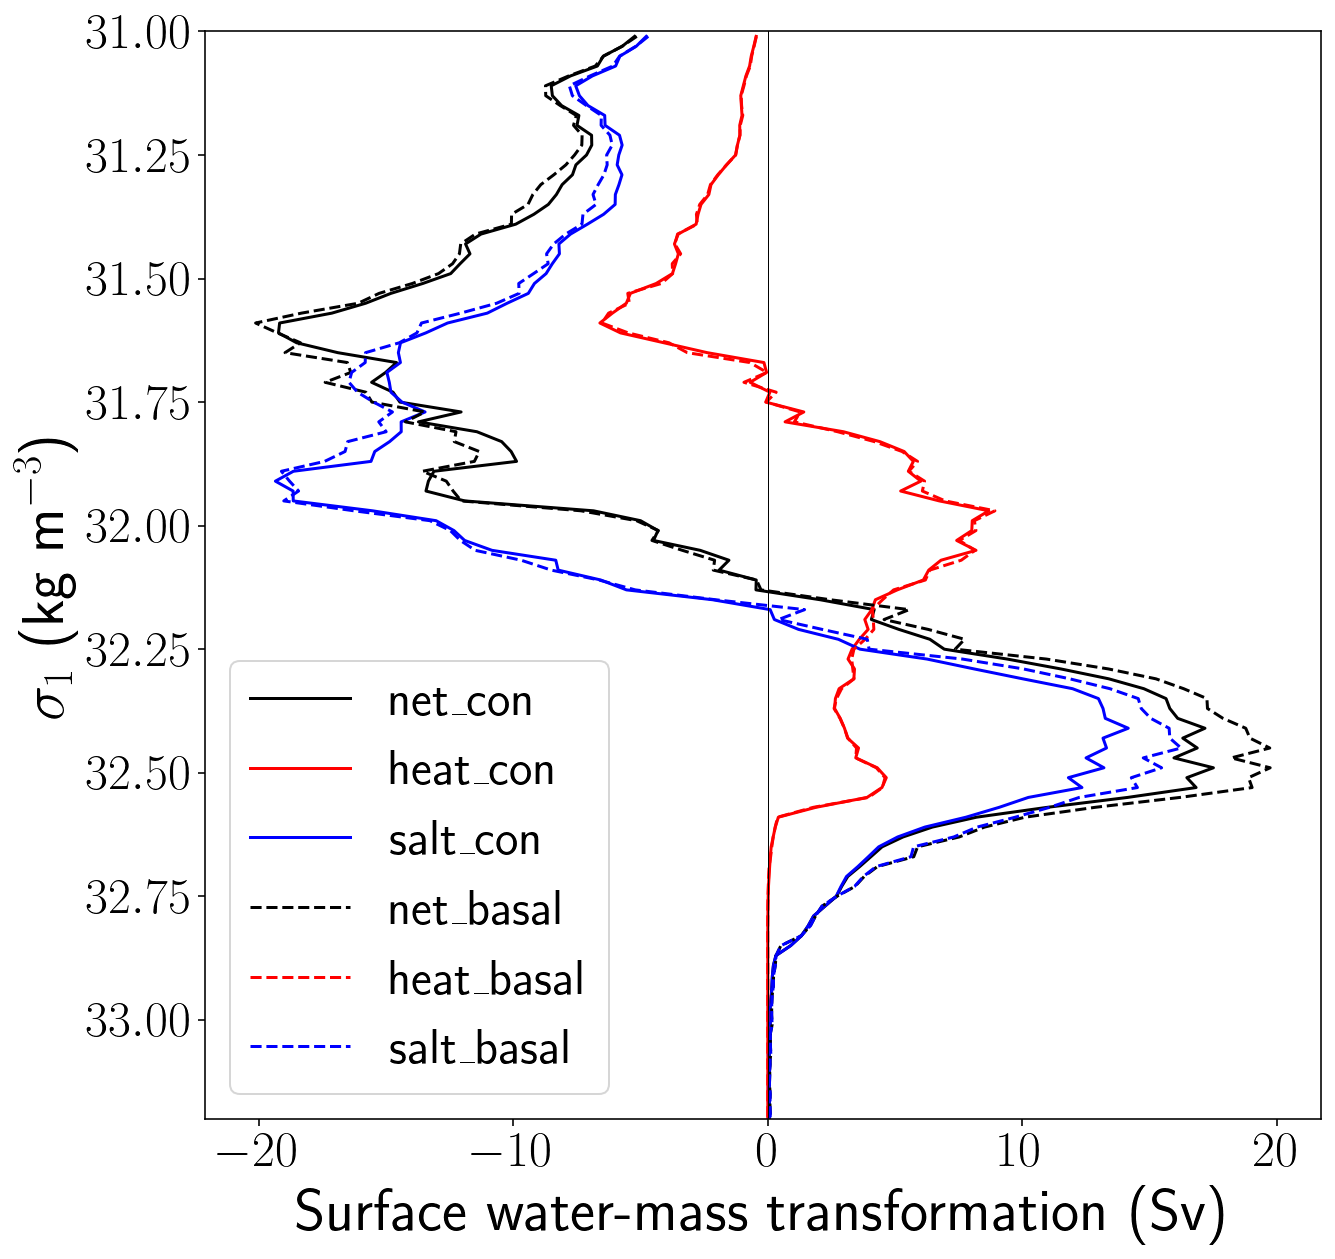

In [23]:
figure = plt.figure(num=1, figsize = (10, 10))
plt.plot(swmt_con_sum,isopycnal_bin_mid_con, color = 'k', label='net_con')
plt.plot(heat_con_sum,isopycnal_bin_mid_con, color = 'r', label='heat_con')
plt.plot(salt_con_sum,isopycnal_bin_mid_con, color = 'b', label='salt_con')
plt.plot(swmt_Tfreezing_min_sum,isopycnal_bin_mid_Tfreezing_min, color = 'k', linestyle='dashed', label='net_basal')
plt.plot(heat_Tfreezing_min_sum,isopycnal_bin_mid_Tfreezing_min, color = 'r', linestyle='dashed', label='heat_basal')
plt.plot(salt_Tfreezing_min_sum,isopycnal_bin_mid_Tfreezing_min, color = 'b', linestyle='dashed', label='salt_basal')
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

In [52]:
#Time evolution

In [15]:
year = 2150
outpath = root+'Tfreezing_min/SWMT_temp/'+str(year)
time_bounds = str(year)+'_1-'+str(year)+'_12'
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # needed for the plots I'll provide.
swmt_Tfreezing_min, heat_Tfreezing_min, salt_Tfreezing_min = get_SWMT(outpath, time_bounds)
## sum over region, convert to Sv
isopycnal_bin_mid_Tfreezing_min = swmt_Tfreezing_min.isopycnal_bins
swmt_Tfreezing_min_sum = (swmt_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_Tfreezing_min_sum = (heat_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_Tfreezing_min_sum = (salt_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values

In [16]:
swmt_Tfreezing_min_sum_T = np.zeros((5,swmt_Tfreezing_min_sum.shape[0] ))
heat_Tfreezing_min_sum_T = np.zeros((5,heat_Tfreezing_min_sum.shape[0] ))
salt_Tfreezing_min_sum_T = np.zeros((5,salt_Tfreezing_min_sum.shape[0] ))
cont=0
for cont in range(5):
    year = 2150 + cont
    outpath = root+'Tfreezing_min/SWMT_temp/'+str(year)
    time_bounds = str(year)+'_1-'+str(year)+'_12'
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # needed for the plots I'll provide.
    swmt_Tfreezing_min, heat_Tfreezing_min, salt_Tfreezing_min = get_SWMT(outpath, time_bounds)
    ## sum over region, convert to Sv
    isopycnal_bin_mid_Tfreezing_min = swmt_Tfreezing_min.isopycnal_bins
    swmt_Tfreezing_min_sum = (swmt_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
    heat_Tfreezing_min_sum = (heat_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
    salt_Tfreezing_min_sum = (salt_Tfreezing_min * area_t/1e6).sum(['xt_ocean', 'yt_ocean']).values
    swmt_Tfreezing_min_sum_T[cont,:] = swmt_Tfreezing_min_sum
    heat_Tfreezing_min_sum_T[cont,:] = heat_Tfreezing_min_sum
    salt_Tfreezing_min_sum_T[cont,:] = salt_Tfreezing_min_sum
    cont = cont +1

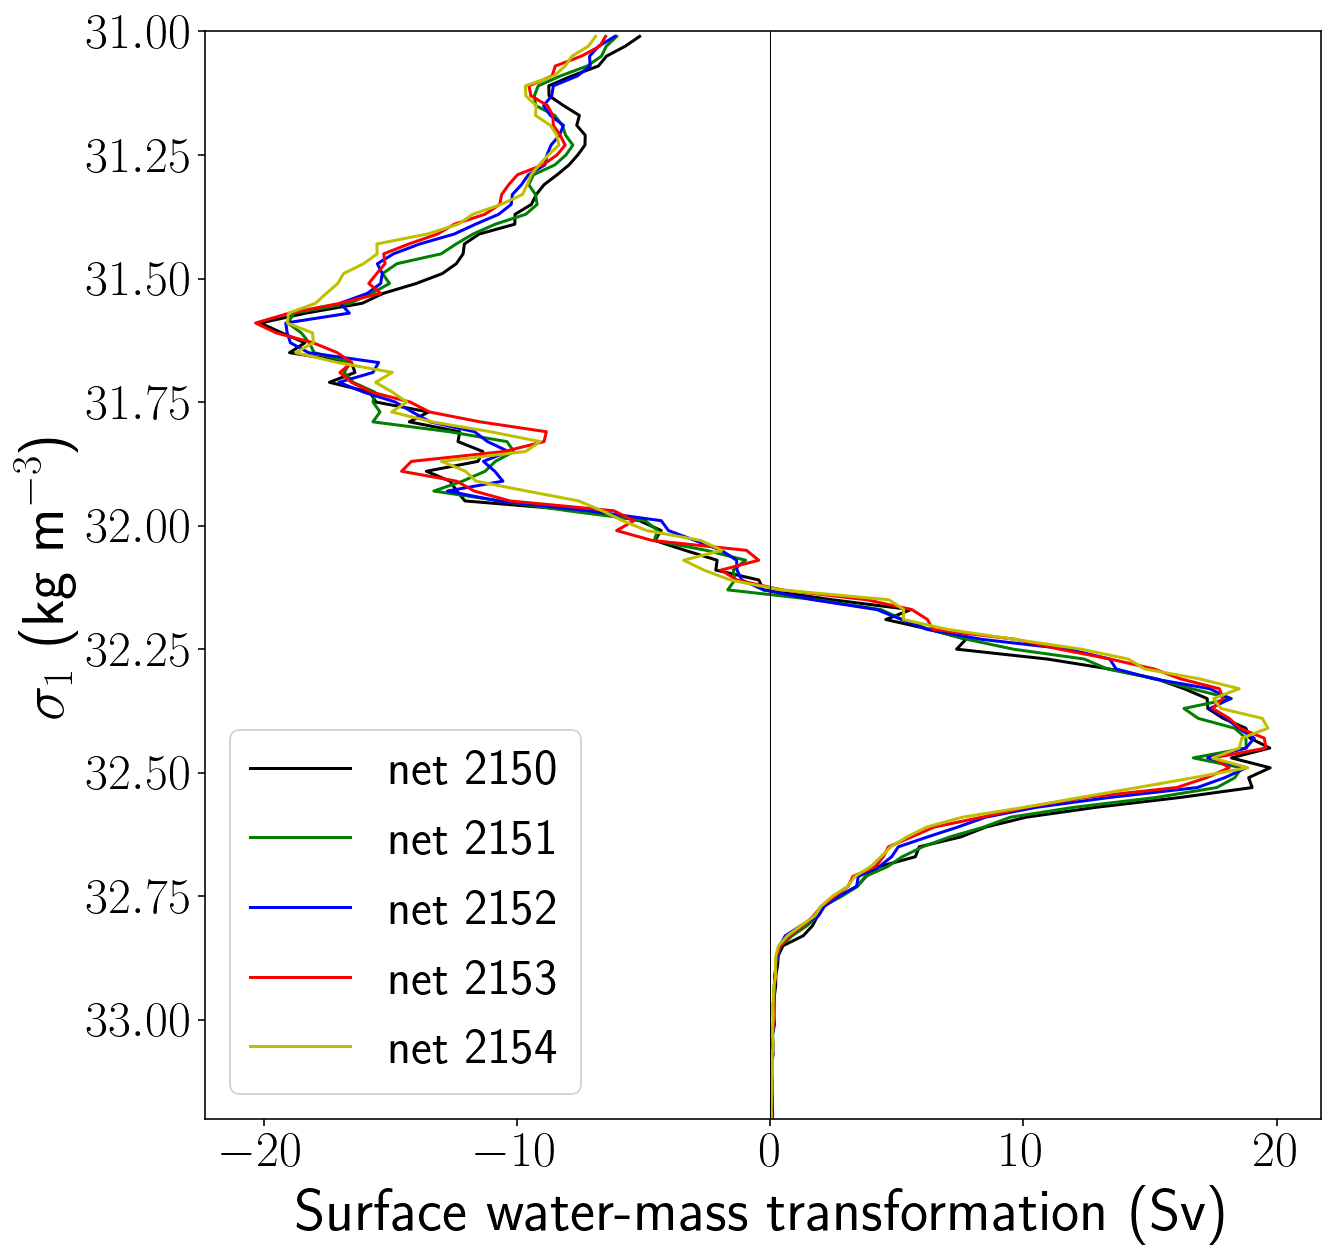

In [18]:
figure = plt.figure(num=1, figsize = (10, 10))
plt.plot(swmt_Tfreezing_min_sum_T[0],isopycnal_bin_mid_Tfreezing_min, color = 'k', label='net 2150')
plt.plot(swmt_Tfreezing_min_sum_T[1],isopycnal_bin_mid_Tfreezing_min, color = 'g', label='net 2151')
plt.plot(swmt_Tfreezing_min_sum_T[2],isopycnal_bin_mid_Tfreezing_min, color = 'b', label='net 2152')
plt.plot(swmt_Tfreezing_min_sum_T[3],isopycnal_bin_mid_Tfreezing_min, color = 'r', label='net 2153')
plt.plot(swmt_Tfreezing_min_sum_T[4],isopycnal_bin_mid_Tfreezing_min, color = 'y', label='net 2154')
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

In [28]:
#On the Shelf

In [31]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

In [32]:
ht = cc.querying.getvar(expt,'ht', session, n=1) 
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

In [40]:
swmt_con_shelf, shelf_mask = shelf_mask_isobath(swmt_con)
heat_con_shelf, shelf_mask = shelf_mask_isobath(heat_con)
salt_con_shelf, shelf_mask = shelf_mask_isobath(salt_con)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
swmt_con_shelf_sum = (swmt_con_shelf * area_t_shelf/1e6).sum(['xt_ocean','yt_ocean']).values
heat_con_shelf_sum = (heat_con_shelf * area_t_shelf/1e6).sum(['xt_ocean','yt_ocean']).values
salt_con_shelf_sum = (salt_con_shelf * area_t_shelf/1e6).sum(['xt_ocean','yt_ocean']).values

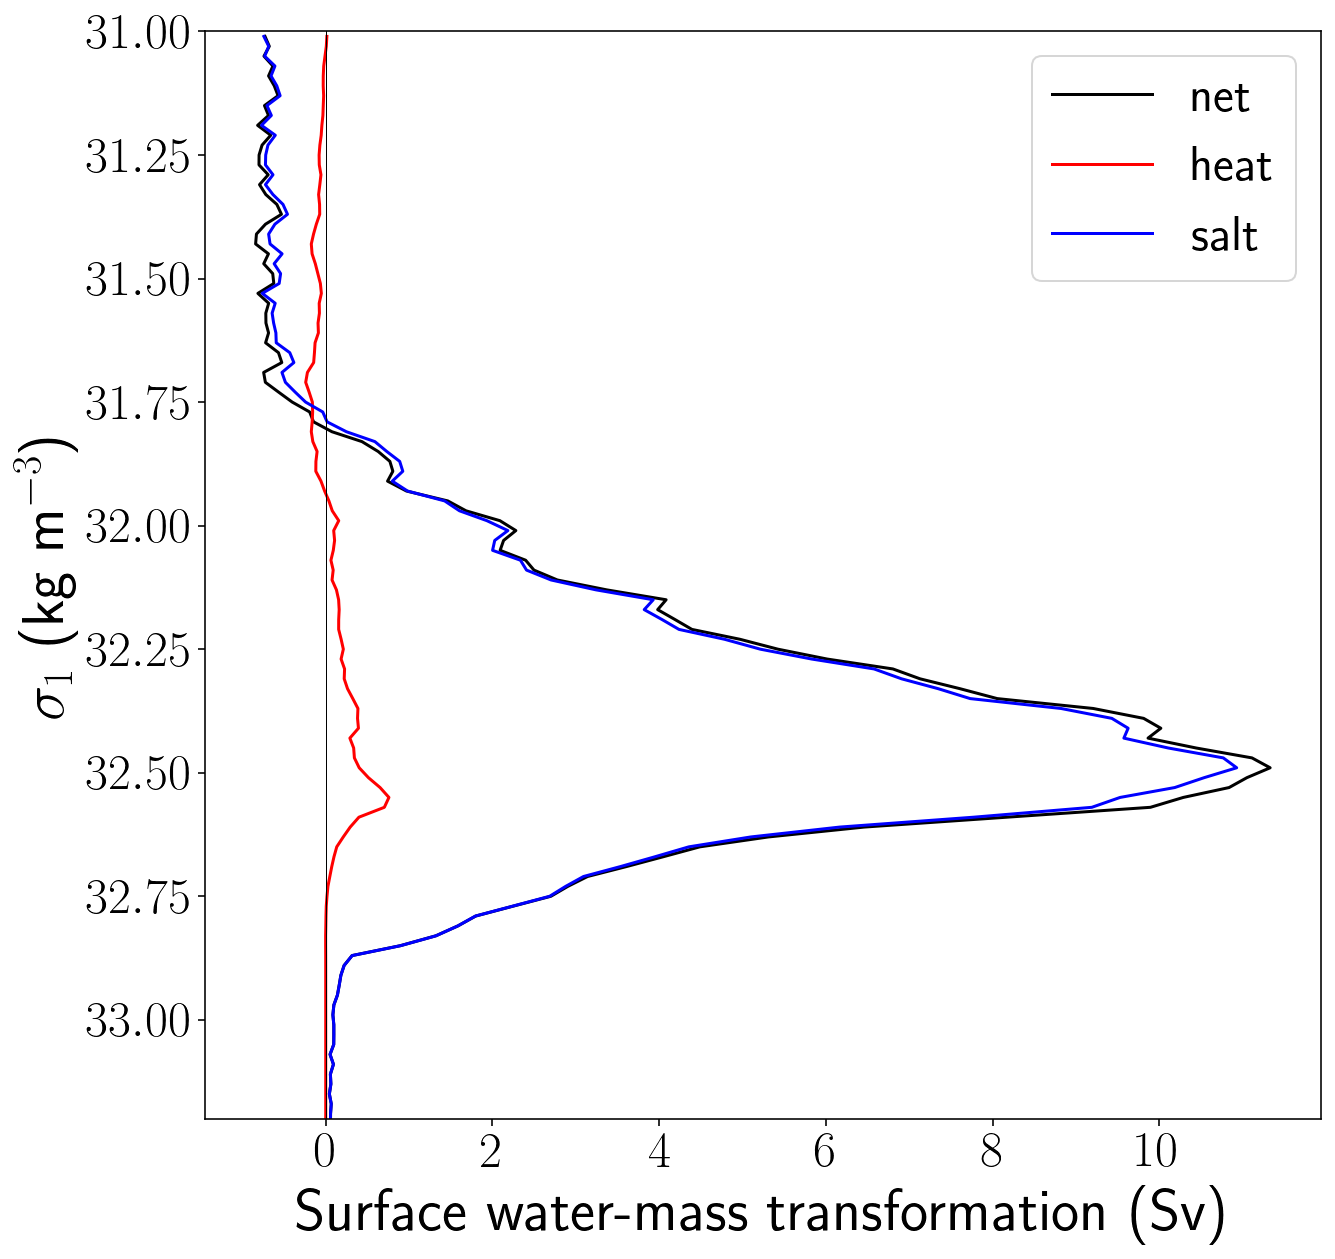

In [41]:
figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_con_shelf_sum, isopycnal_bin_mid_con, color = 'k',label='net')
plt.plot(heat_con_shelf_sum, isopycnal_bin_mid_con, color = 'r',label='heat')
plt.plot(salt_con_shelf_sum, isopycnal_bin_mid_con, color = 'b',label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);

In [36]:
swmt_Tfreezing_min_shelf, shelf_mask = shelf_mask_isobath(swmt_Tfreezing_min)
heat_Tfreezing_min_shelf, shelf_mask = shelf_mask_isobath(heat_Tfreezing_min)
salt_Tfreezing_min_shelf, shelf_mask = shelf_mask_isobath(salt_Tfreezing_min)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
swmt_Tfreezing_min_shelf_sum = (swmt_Tfreezing_min_shelf * area_t_shelf/1e6).sum(['xt_ocean','yt_ocean']).values
heat_Tfreezing_min_shelf_sum = (heat_Tfreezing_min_shelf * area_t_shelf/1e6).sum(['xt_ocean','yt_ocean']).values
salt_Tfreezing_min_shelf_sum = (salt_Tfreezing_min_shelf * area_t_shelf/1e6).sum(['xt_ocean','yt_ocean']).values

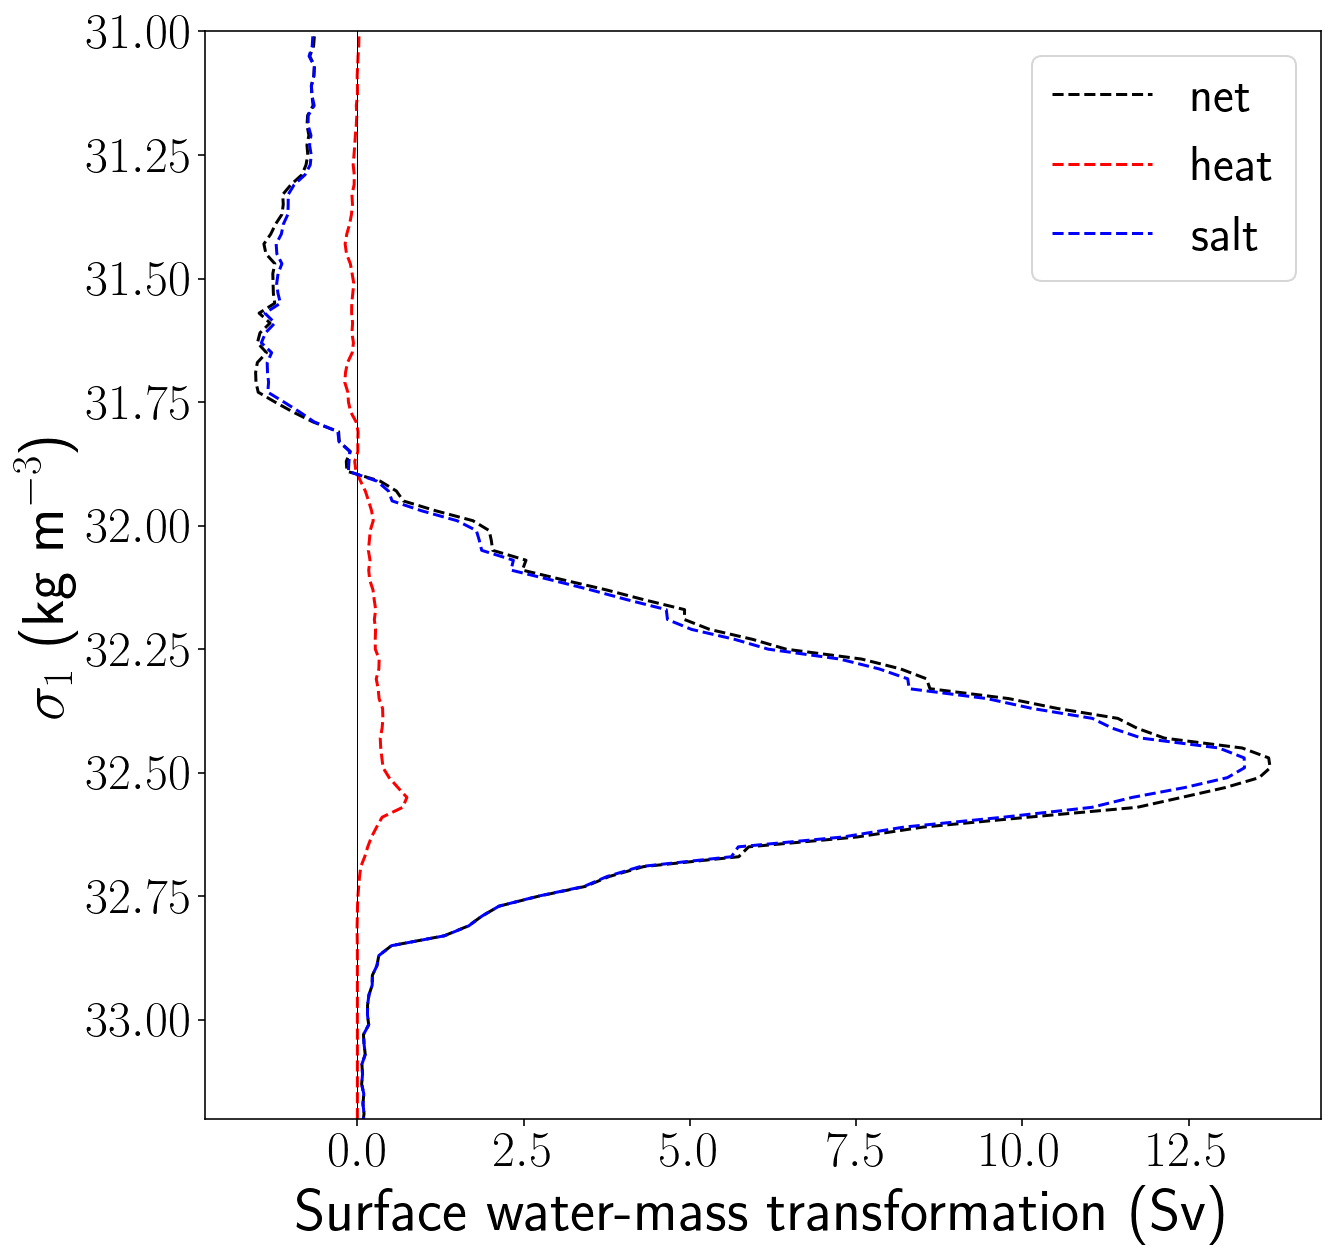

In [39]:
figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_Tfreezing_min_shelf_sum, isopycnal_bin_mid_Tfreezing_min, color = 'k', linestyle='dashed',label='net')
plt.plot(heat_Tfreezing_min_shelf_sum, isopycnal_bin_mid_Tfreezing_min, color = 'r', linestyle='dashed',label='heat')
plt.plot(salt_Tfreezing_min_shelf_sum, isopycnal_bin_mid_Tfreezing_min, color = 'b', linestyle='dashed',label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);

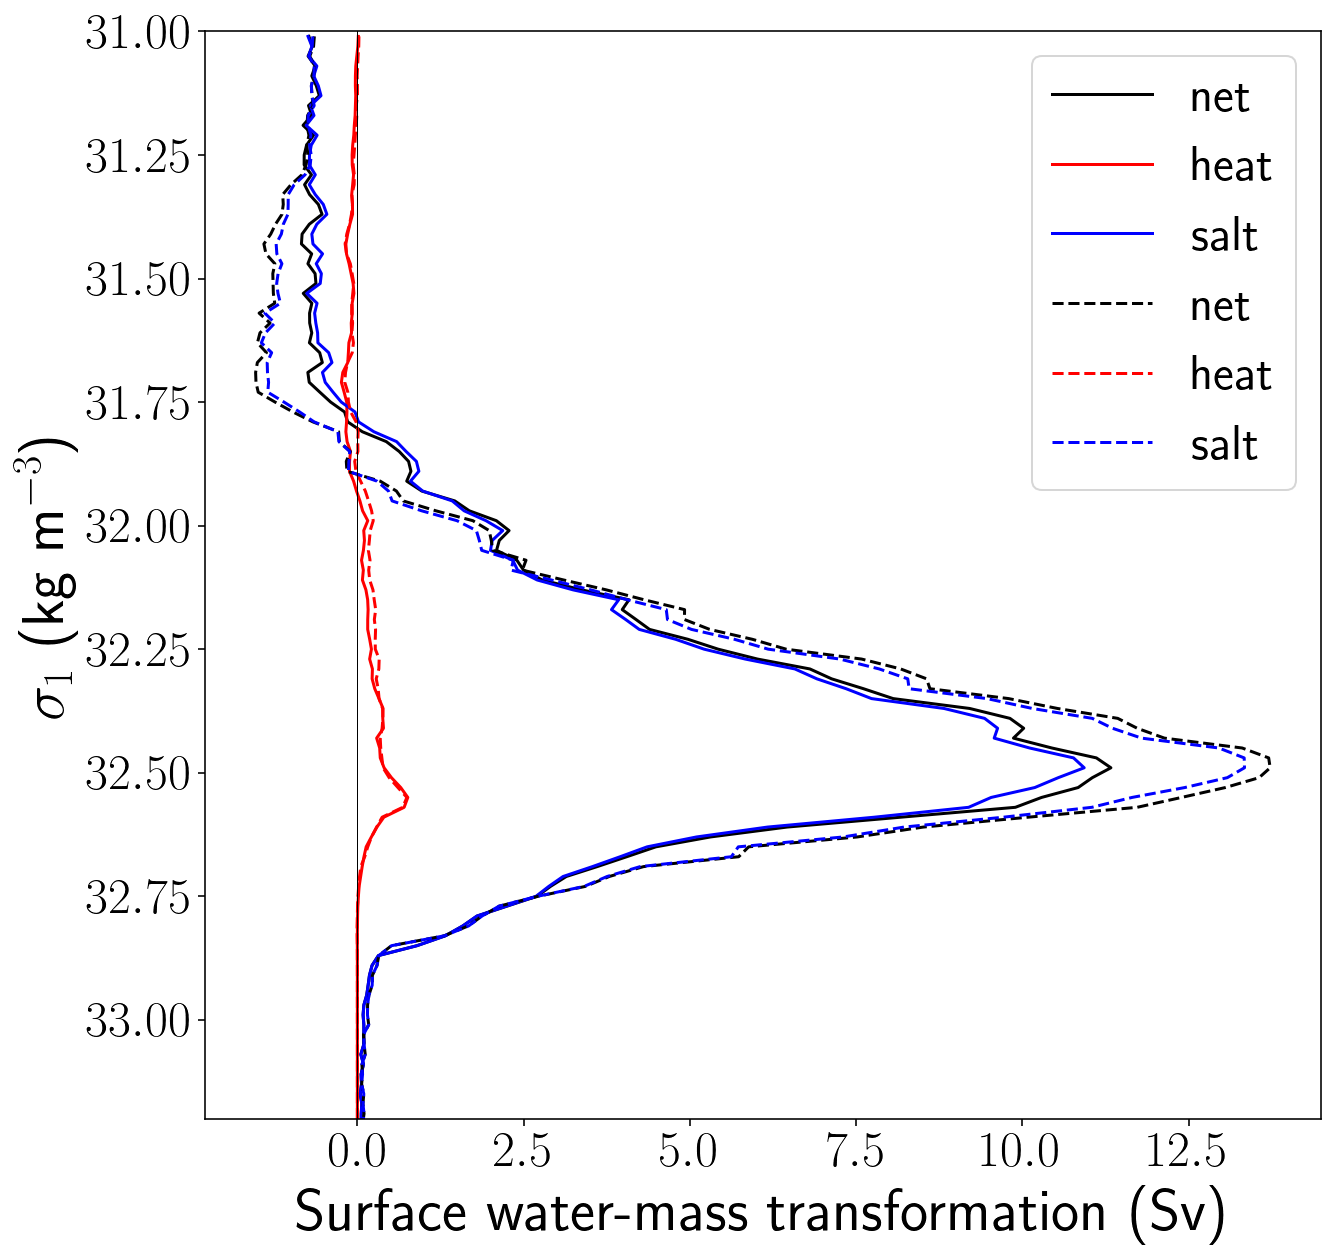

In [42]:
figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_con_shelf_sum, isopycnal_bin_mid_con, color = 'k',label='net')
plt.plot(heat_con_shelf_sum, isopycnal_bin_mid_con, color = 'r',label='heat')
plt.plot(salt_con_shelf_sum, isopycnal_bin_mid_con, color = 'b',label='salt')
plt.plot(swmt_Tfreezing_min_shelf_sum, isopycnal_bin_mid_Tfreezing_min, color = 'k', linestyle='dashed',label='net')
plt.plot(heat_Tfreezing_min_shelf_sum, isopycnal_bin_mid_Tfreezing_min, color = 'r', linestyle='dashed',label='heat')
plt.plot(salt_Tfreezing_min_shelf_sum, isopycnal_bin_mid_Tfreezing_min, color = 'b', linestyle='dashed',label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);

In [43]:
#Surface maps

In [58]:
max_transformation_index_con = np.argmax(swmt_con_shelf_sum)
max_transformation_density = isopycnal_bin_mid_con[max_transformation_index_con]
print('Shelf subduction density:',max_transformation_density.values)

shelf_diff = (swmt_con_shelf.isel(isopycnal_bins = max_transformation_index_con) - swmt_Tfreezing_min_shelf.isel(isopycnal_bins = max_transformation_index_Tfreezing_min) )
#shelf_subduction_plot = swmt_con_shelf.isel(isopycnal_bins = max_transformation_index_con)*1e5
shelf_subduction_plot = shelf_diff * 1e6
swmt_xt = shelf_subduction_plot.xt_ocean
swmt_yt = shelf_subduction_plot.yt_ocean

Shelf subduction density: 32.48999999999997


  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)

  ax.outline_patch.set_visible(False)



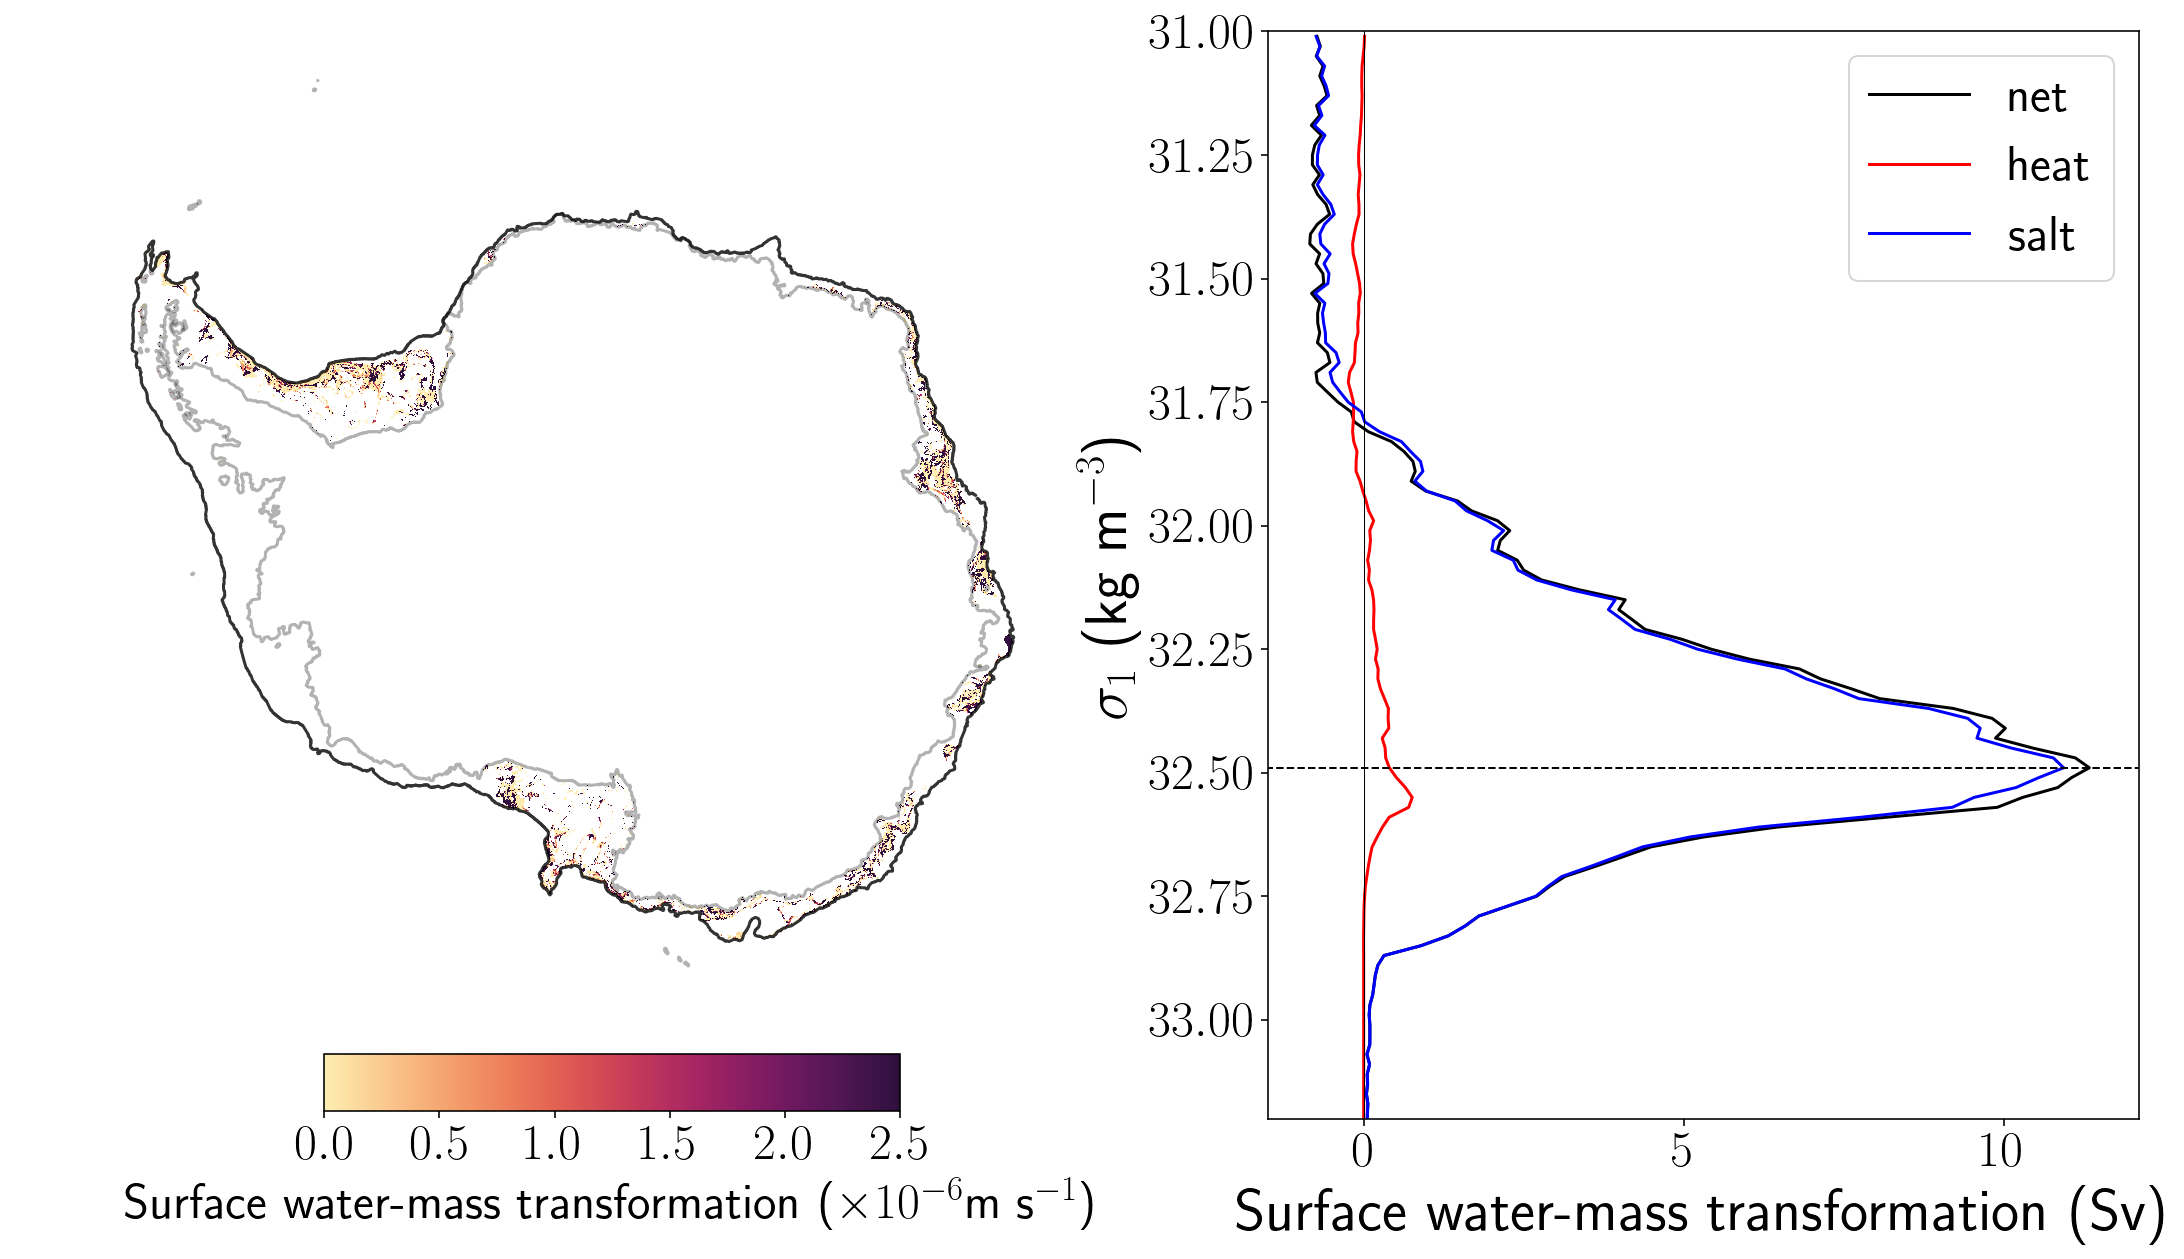

In [59]:
fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [3, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1])

ax.contour(xt_ocean, yt_ocean,land_mask, [0, 1],
           colors = 'k', alpha = 0.3, transform = ccrs.PlateCarree() )
ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask, [0, 1],
           colors='k', alpha =0.8, transform = ccrs.PlateCarree())

norm = col.Normalize(vmin=0, vmax=2.5)

plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot,
                          vmin=0, vmax=2.5, cmap=cmo.matter,transform=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
ax.outline_patch.set_visible(False)

cax = fig.add_axes([0.27, 0.13, 0.2, 0.04])
cbar=plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-6}$m s$^{-1}$)', fontsize = 25)

ax1.plot(swmt_con_shelf_sum,isopycnal_bin_mid_con, color = 'k',label='net')
ax1.plot(heat_con_shelf_sum,isopycnal_bin_mid_con, color = 'r',label='heat')
ax1.plot(salt_con_shelf_sum,isopycnal_bin_mid_con, color = 'b',label='salt')
ax1.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15],[max_transformation_density, max_transformation_density],'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 12.1))
ax1.set_ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 30)
ax1.set_xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
ax1.legend(loc=1, fontsize = 25);